# TP3

In [159]:
# Common libraries
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [160]:
# Set image repo
ImgFolder = "..\\..\\Material_TPs\\TP3\\"

# Quick function to plot to matplotlib
def rgbPlot(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()
    return

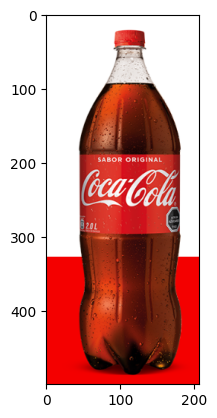

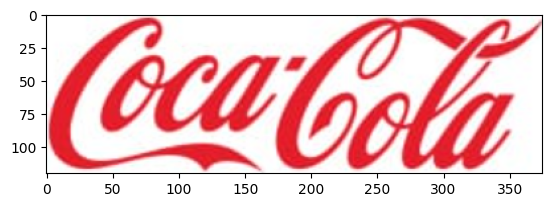

In [161]:
# Load the template
img = cv.imread(ImgFolder + '\\images\\coca_logo_1.png')
template_ = cv.imread(ImgFolder + '\\template\\pattern.png')
# Remove weird borders
template = template_[30:-25,10:-15,:]
rgbPlot(img)
rgbPlot(template)

## cv2.matchTemplate()
De la documentación de OpenCV:

The function slides through image , compares the overlapped patches of size $w \times  h$ against template using the specified method and stores the comparison results in result (...).

After the function finishes the comparison, the best matches can be found as global minimums (when TM_SQDIFF was used) or maximums (when TM_CCORR or TM_CCOEFF was used) using the minMaxLoc function. In case of a color image, template summation in the numerator and each sum in the denominator is done over all of the channels and separate mean values are used for each channel. That is, the function can take a color template and a color image. The result will still be a single-channel image, which is easier to analyze.

## Multi-scale pattern matching
Pattern matching no es la herramienta adecuada cuando el patrón tienen diferentes tamaños en el template y en la imagen a analizar. Es totalmente inutil cuando el patrón puede haber sufrido transformaciones en la imagen: rotaciones, warpings y demás. Para eso hay que usar keypoint matching.

Sin embargo, para lo primero, se puede variar el tamaño del template (o la imagen) hasta dar con la mejor correlación.

### Prueba de concepto
Para logos, conviene extraer los bordes ya que son suficientemente distintivos para reconocerlos, además de que nos libramos de variaciones de color por diferencias de iluminación y cualquier otra calamidad que pueda traer una imagen multicanal. 

En este caso, voy a intenar encontrar el tamaño a mano.

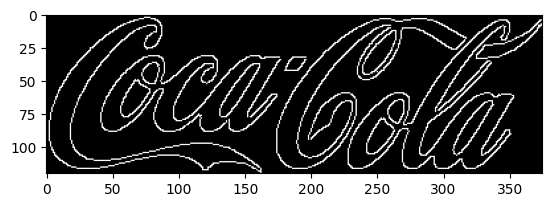

In [162]:
template_edge = cv.Canny(template,150,300)
plt.imshow(template_edge,cmap='gray')

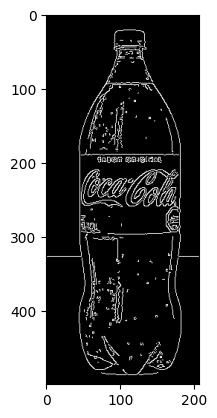

In [163]:
img_edge = cv.Canny(img,200,300)
plt.imshow(img_edge,cmap='gray')


In [164]:
#cv.matchTemplate(img_edge,template_edge,cv.TM_SQDIFF)

Ya empezamos mal porque el template es más grande que la imagen. Empiezo, entonces, bajando el tamaño del template con cv2.resize(). Conviene hacer Canny y despues resize, o viceversa?

(-0.5, 74.5, 23.5, -0.5)

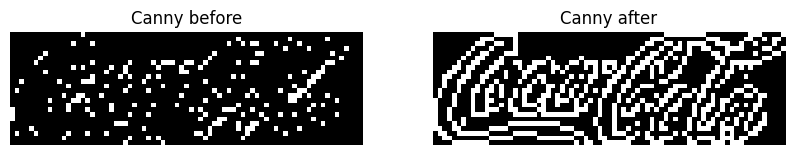

In [165]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(cv.resize(template_edge,dsize=None,fx=0.2,fy=0.2,interpolation=cv.INTER_LANCZOS4), cmap='gray')
ax[0].axis("off")
ax[0].set_title("Canny before")
ax[1].imshow(cv.Canny(cv.resize(template,dsize=None,fx=0.2,fy=0.2,interpolation=cv.INTER_LANCZOS4),150,2), cmap='gray')
ax[1].set_title("Canny after")
ax[1].axis("off")

Claramente es mejor resize y después Canny. De todas formas, parece  que la interpolación en operaciones de shrinking no le sienta bien Canny. Si aumento el tamaño de la imagen a inspeccionar?


(-0.5, 372.5, 899.5, -0.5)

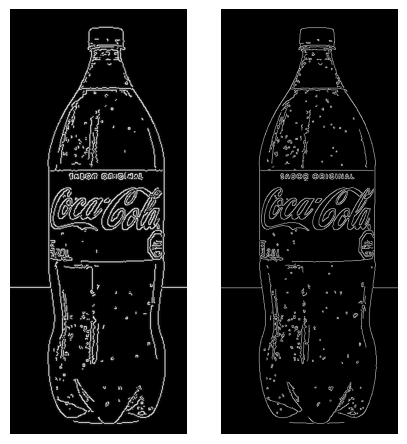

In [166]:
fig, ax = plt.subplots(1,2,figsize=(5,10))
ax[0].imshow(cv.resize(img_edge,dsize=None,fx=1.8,fy=1.8,interpolation=cv.INTER_LANCZOS4), cmap='gray')
ax[0].axis("off")
ax[1].imshow(cv.Canny(cv.resize(img,dsize=None,fx=1.8,fy=1.8,interpolation=cv.INTER_LANCZOS4),150,300), cmap='gray')
ax[1].axis("off")

Es mucho mejor la agrandar las imágenes, pero no puedo pensar en algo más agresivo para la memoria. Voy a quedarme con el shrinking y arriesgar matchings pobres en vez de llenar la RAM con templates en 4k. De paso, uso Multi-object pattern matching dibujando un rectangulo en todos los puntos que superen un cierto umbral, del método normalizado elegido.

Best correlation: 0.15117036


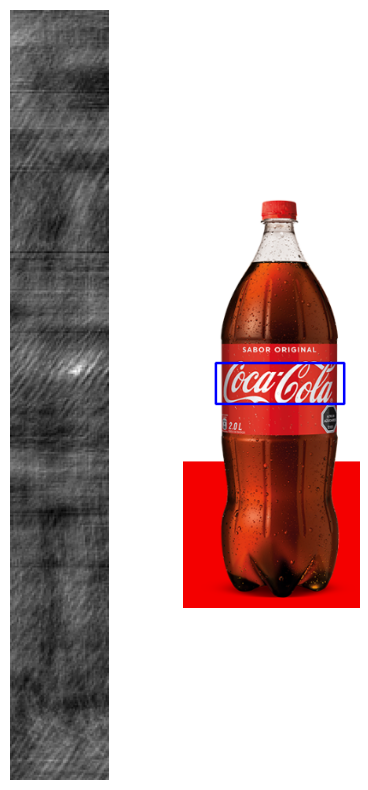

In [167]:
tmplt_resize_edges = cv.Canny(cv.resize(template,dsize=None,fx=0.4,fy=0.4,interpolation=cv.INTER_LANCZOS4),200,300)
w, h = tmplt_resize_edges.shape[::-1]
res = cv.matchTemplate(img_edge,tmplt_resize_edges,cv.TM_CCOEFF_NORMED)
threshold = res.max()
img_res = img.copy()
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_res, pt, (pt[0] + w, pt[1] + h), (255,0,0), 2)
fig, ax = plt.subplots(1,2,figsize=(5,10))
ax[0].imshow(res, cmap='gray')
ax[0].axis("off")
ax[1].imshow(cv.cvtColor(img_res,cv.COLOR_BGR2RGB))
ax[1].axis("off")
print("Best correlation:",res.max())

Ese match fue encontrado despues de algunas pruebas manuales. El match es bastante malo, pero lo encontró donde va. 

Best correlation: 0.27574822


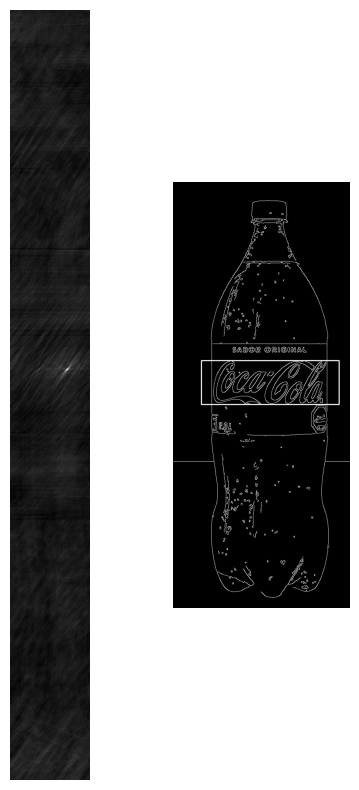

In [168]:
img_resize_edges = cv.Canny(cv.resize(img,dsize=None,fx=2.33,fy=2.33,interpolation=cv.INTER_CUBIC),150,300)
w, h = template_edge.shape[::-1]
res = cv.matchTemplate(img_resize_edges,template_edge,cv.TM_CCOEFF_NORMED)
threshold = 0.25
img_res = img.copy()
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_resize_edges, pt, (pt[0] + w, pt[1] + h), (255,0,0), 2)
fig, ax = plt.subplots(1,2,figsize=(5,10))
ax[0].imshow(res, cmap='gray')
ax[0].axis("off")
ax[1].imshow(img_resize_edges, cmap='gray')
ax[1].axis("off")
print("Best correlation:",res.max())

Las correlaciones fueron muy parecidas, con el upscaling ligeramente mejor.

## Multi scale, multi object pattern matching

La estrategia a usar es buscar la dimensión del template que se más grande, o más cercana, que las dimensiones de la imagen a inspeccionar. Con eso obtengo un ratio para re-dimensionar el template (tanto up como downscaling, según necesario), de forma que quede esa dimensión igual a la de la imagen. Luego, tomo N "epochs", o N diferentes escalas entre una mínimo (min_scale) escalado por el ratio obtenido, hasta el tamaño del template * ratio.

En cada iteración, se escala la imagen (queda probar cambiando el método de interpolación porque según OpenCV, la linear es mejor para achicar y la cúbica para agrandar), se aplica Canny y se hace el pattern matching de OpenCV con el método CCOEF_NORMED (hubiera preferido diferencia de cuadrados pero parece no funcionar con Canny), normalizado para poder asignar un umbral generalizado.

Por cada iteración, se registra cada match y se dibuja un rectangulo, apropiadamente escalado, del template en la imagen a inspeccionar y se devuelve anotada con la correlación en cada punto.

In [169]:
def MSMO_matchPattern(img,template,epochs=20,threshold=0.33,min_scale=0.3,canny_thresholds = (150,300)):
    rX = template.shape[0]/img.shape[0]
    rY = template.shape[1]/img.shape[1]
    ratio = 1/max(rX,rY)
    
    template_resize = cv.resize(template,(
        int(np.clip((template.shape[1]*ratio),a_min = 0, a_max = img.shape[1])),
        int(np.clip((template.shape[0]*ratio),a_min = 0, a_max = img.shape[0]))
    ))

    max_size = ratio
    min_size = min_scale * max_size

    matches = []
    img_res = img.copy()

    for scale in np.linspace(min_size,max_size,epochs):
        # Scale template
        template_resize = cv.resize(template,(
            int(np.clip((template.shape[1]*scale),a_min = 0, a_max = img.shape[1])),
            int(np.clip((template.shape[0]*scale),a_min = 0, a_max = img.shape[0]))
        ))
        template_resize_edges = cv.Canny(template_resize,canny_thresholds[0],canny_thresholds[1])
        w, h = template_resize_edges.shape[::-1]
        res = cv.matchTemplate(cv.Canny(img,canny_thresholds[0],canny_thresholds[1]),
                               template_resize_edges,
                               cv.TM_CCOEFF_NORMED)
        loc = np.where( res >= threshold)
        for pt in zip(*loc[::-1]):
            matches.append((pt,scale,res[pt[1],pt[0]]))
            cv.rectangle(img_res, pt, (pt[0] + w, pt[1] + h), (255,0,0), 2)
            cv.putText(img_res,
                       'Corr ' + str(res[pt[1],pt[0]]), 
                       pt, 
                       cv.FONT_HERSHEY_SIMPLEX, 
                       0.5, 
                       (255,0,0), 
                       1, 
                       cv.LINE_AA)
    return img_res,matches

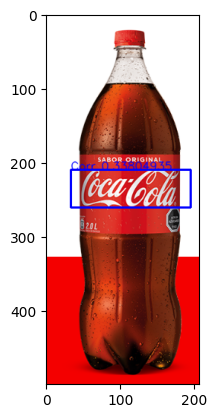

In [170]:
img_res, _ = MSMO_matchPattern(img,template,threshold=0.33)
rgbPlot(img_res)

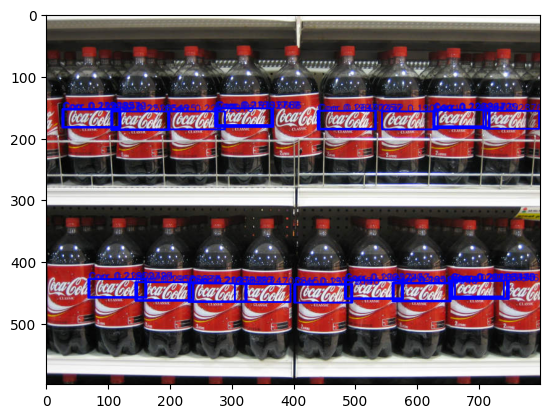

In [171]:
img = cv.imread(ImgFolder + 'images\\coca_multi.png')
img_res, _ = MSMO_matchPattern(img,template,threshold=0.19,epochs=200,min_scale=0.1)
rgbPlot(img_res)

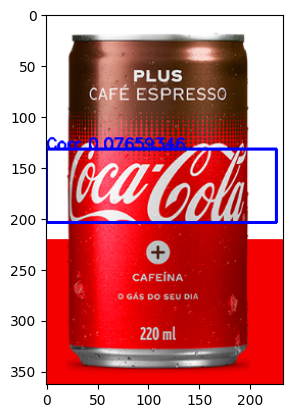

In [172]:
img = cv.imread(ImgFolder + 'images\\coca_logo_2.png')
img_res, _ = MSMO_matchPattern(img,template,threshold=0.0755,epochs=200,min_scale=0.9)
rgbPlot(img_res)

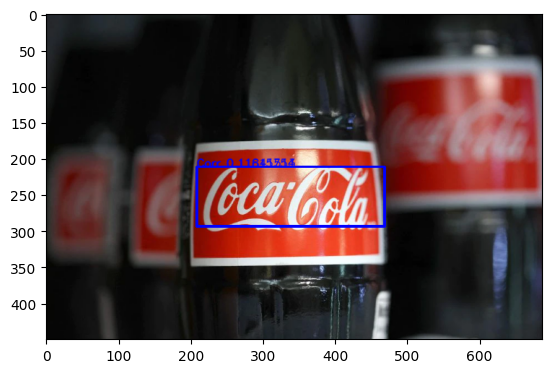

In [173]:
img = cv.imread(ImgFolder + 'images\\logo_1.png')
img_res, _ = MSMO_matchPattern(img,template,threshold=0.115,epochs=200,min_scale=0.30)
rgbPlot(img_res)

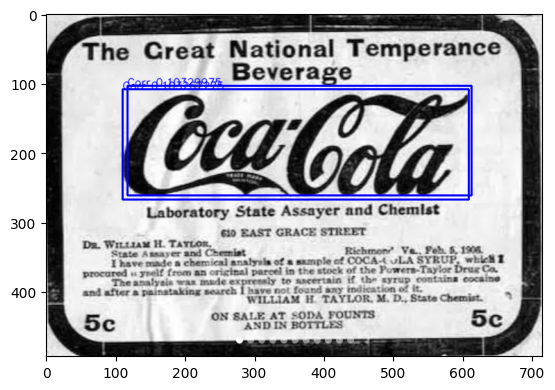

In [174]:
img = cv.imread(ImgFolder + 'images\\coca_retro_1.png')
img_res, _ = MSMO_matchPattern(img,template,threshold=0.1,epochs=200,min_scale=0.25)
rgbPlot(img_res)

## Conclusión

MSMO resultó ser lento, impreciso y requiere de demasiados ajustes. Además, como era de esperar, falla catastróficamente si el template en la imagen tiene una ligera transformación, evidenciado por la baja correlación en todas las botellas (warping cilindrico) y en la último imagen (rotación). 

Se podría tratar de buscar automaticamente un threshold (encontrando el máximo/mínimo de correlación), pero falla si realmente el patrón no está en la imagen. También se podría limitar la cantidad de matches (y por lo tanto rectangulos en la presentación final), al definir círculos de radio arbitario en cada punto detectado, establecer una cantidad de matches mínimo para "detección", encontrar su centro geómetrico y dibujar ahí el rectangulo.

De todas formas, no creo que valga la pena más trabajo sobre esto.